### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import os
import aux_tools as aux
import Tabesh2013functions as tbsh
from collections import defaultdict

### Dataframe

In [2]:
mina_df = pd.read_csv('CP_fases.txt', sep="\s+")
mina_df.rename(columns={'0': 'id'}, inplace=True)

combinaciones = (
    mina_df[['fase', 'z']]
    .drop_duplicates()
    .sort_values(['fase', 'z'], ascending=[True, False])
)

# Asignar número de banco por grupo de fase
combinaciones['banco'] = (
    combinaciones.groupby('fase').cumcount() + 1
)

# Unir esta info de vuelta al df original
mina_df = mina_df.merge(combinaciones, on=['fase', 'z'], how='left')

mina_df.head()

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id,banco
0,491425.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,1,22
1,491435.0,7456195.0,1968.0,0.266522,1.057851,0.640223,0.021141,0.491924,2.626056,8,0.197908,68.839492,87.471598,0.042976,2,4,2,22
2,491445.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,3,22
3,491455.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,4,22
4,491435.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,5,22


### Graficar

Ejemplo de los graficos

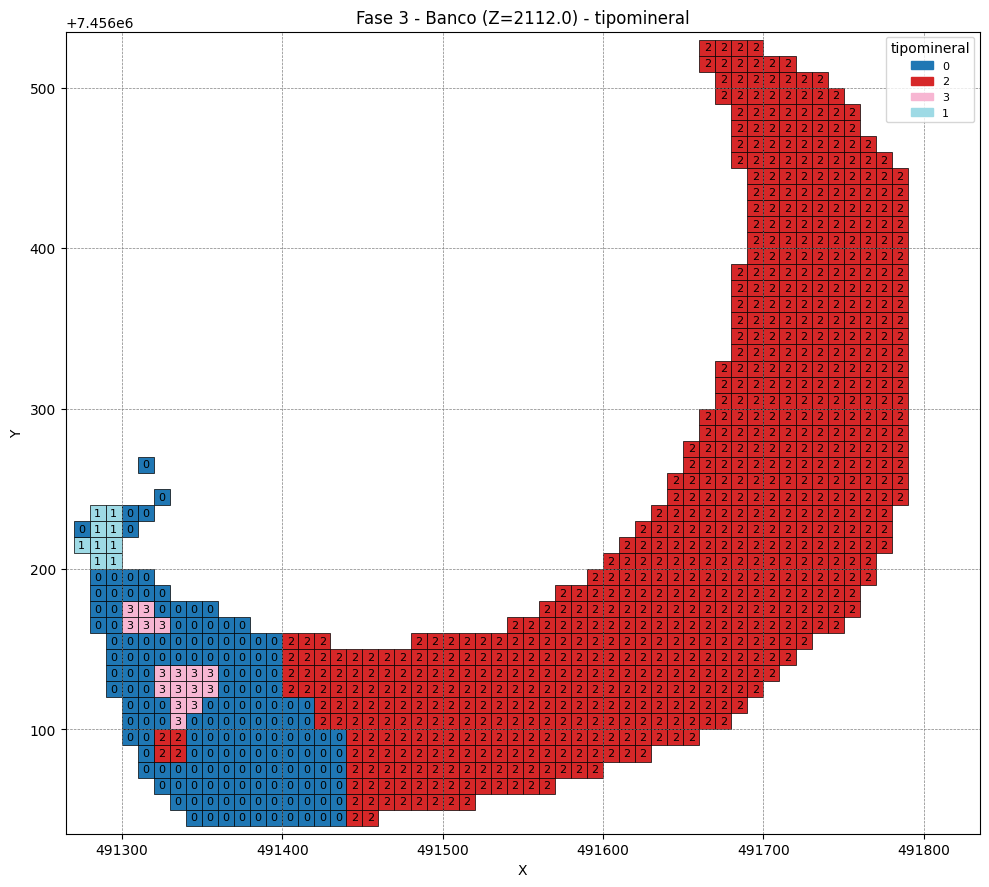

In [4]:
f,b = 3,15
df_filtrado = mina_df[(mina_df['fase']==f)&(mina_df['banco']==b)]
tbsh.plot_fase_banco(df_filtrado, column_hue= 'tipomineral')

Tratando 'tipomineral' como Categórica (4 valores únicos).


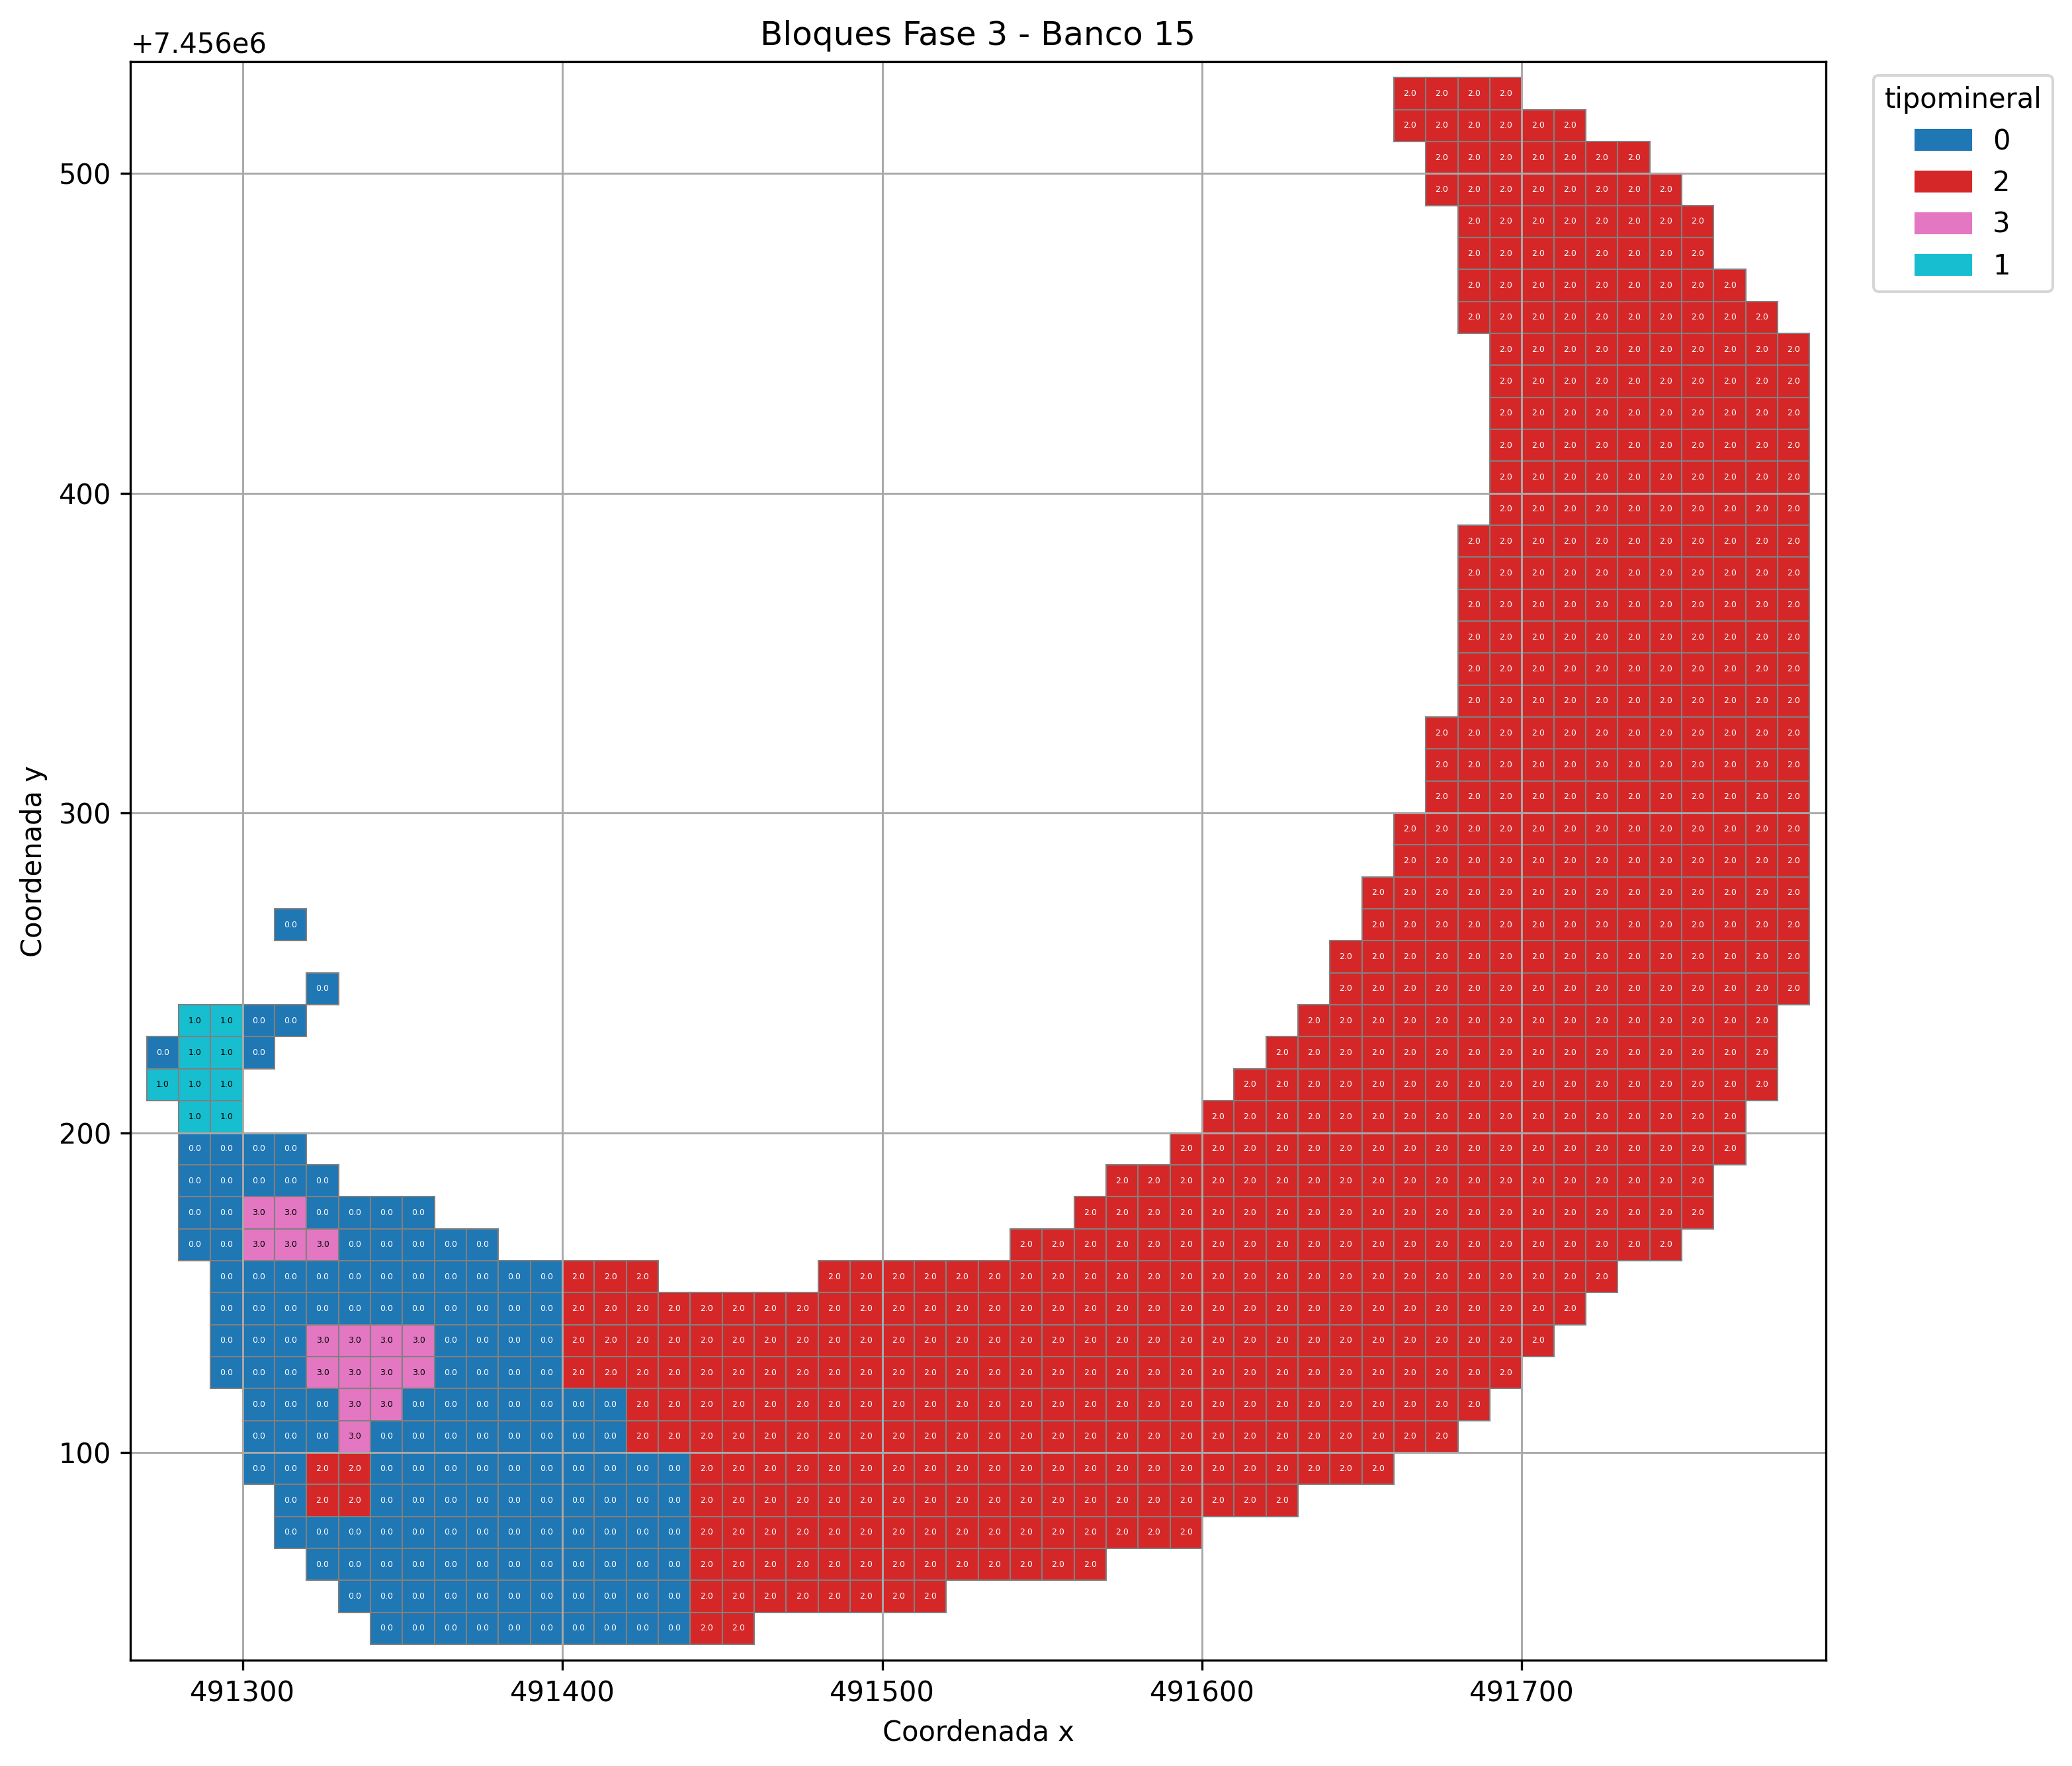

In [9]:
aux.plot_mine_blocks_adv(df_filtrado,
                     color_by_col='tipomineral',
                     title=f"Bloques Fase {f} - Banco {b}",
                     show_block_labels=True, # Mostrar el número de fase
                     fontsize_block_label=3, block_width=10, block_height=10, dpi=300)

### Funciones Aglomeración jerarquica

In [3]:
f,b = 1,6
sub_df = mina_df[(mina_df['fase']==f)&(mina_df['banco']==b)]
len(sub_df)

1859

In [5]:
sub_df

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id,banco
55483,491495.0,7456175.0,2224.0,0.040066,0.275484,0.095400,0.035680,0.095400,2.553693,0,0.0,0.0,0.0,0.374004,0,1,55484,6
56246,491485.0,7456195.0,2224.0,0.032408,0.243367,0.084278,0.055185,0.084278,2.566427,0,0.0,0.0,0.0,0.654801,0,1,56247,6
56249,491485.0,7456205.0,2224.0,0.042572,0.226070,0.078288,0.038837,0.078288,2.591766,0,0.0,0.0,0.0,0.496075,0,1,56250,6
56268,491495.0,7456185.0,2224.0,0.032408,0.243367,0.084278,0.055185,0.084278,2.566427,0,0.0,0.0,0.0,0.654801,0,1,56269,6
56269,491505.0,7456185.0,2224.0,0.030825,0.252373,0.087397,0.053548,0.087397,2.581200,0,0.0,0.0,0.0,0.612699,0,1,56270,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68937,491465.0,7456665.0,2224.0,0.019213,0.382559,0.158419,0.108060,0.158419,2.574546,1,0.0,0.0,0.0,0.682120,1,1,68938,6
68938,491475.0,7456665.0,2224.0,0.019213,0.382559,0.130268,0.074730,0.130268,2.574546,1,0.0,0.0,0.0,0.573660,1,1,68939,6
68939,491485.0,7456665.0,2224.0,0.012259,0.409440,0.141789,0.097543,0.141789,2.622295,1,0.0,0.0,0.0,0.687944,1,1,68940,6
68964,491495.0,7456665.0,2224.0,0.012259,0.409440,0.141789,0.097543,0.141789,2.622295,1,0.0,0.0,0.0,0.687944,1,1,68965,6


In [32]:
start = time.time()
A,_ = aux.construir_matriz_adyacencia(sub_df) 
S = aux.calcular_matriz_similitud_completa(sub_df)
end = time.time()
print(end-start)                    

17.20530128479004


In [8]:
start = time.time()
A = tbsh.Calculate_Adjency_Matrix(sub_df) 
S = tbsh.Calculate_Similarity_Matrix(sub_df, destino = False, ley = True)
end = time.time()
print(end-start)          

0.3664376735687256


In [33]:
l = aux.hierarchical_mine_clustering_adaptado2(sub_df, A, S, 100, 10)

In [41]:
len(l)

266

In [39]:
l2 = aux.hierarchical_mine_clustering_adaptado(sub_df, A, S, 100, 10)

In [42]:
len(l2)

29

Celda de Clustering

In [3]:
df_mina_sim = mina_df.copy()


print("df_mina simulado:")
print(df_mina_sim.head())
print("\nFases y Bancos presentes:")
print(df_mina_sim.groupby(['fase', 'banco']).size())

# 2. Definir parámetros
fases_a_procesar = sorted(df_mina_sim['fase'].unique()) # Procesar todas las fases encontradas
clustering_params = {
    'max_cluster_size': 100,
    'target_num_clusters_per_bench': 4, # Target por banco
    'distancia_adyacencia': 10.0,       # Ajustar a la escala x,y
    'wd': 3,
    'wg': 2,
    'r': 0.5,                          # Factor si material es distinto
    'penalty_factor_c': 0.0001,           # Penalización si clusters de abajo difieren
    'banco_col': 'banco'               # Nombre de la columna de banco
}

# 3. Ejecutar el proceso completo
df_mina_clustered, cluster_details = aux.cluster_mina_por_fase_banco(
    df_mina=df_mina_sim,
    fases_a_procesar=fases_a_procesar,
    **clustering_params
)

# 4. Verificar resultados en el DataFrame principal
print("\n--- Verificación de Resultados en df_mina ---")
print(df_mina_clustered[['id', 'fase', 'banco', 'final_cluster_id', 'final_cluster_label']].head(10))
print("\nDistribución de Clusters Finales por Banco:")
print(df_mina_clustered[df_mina_clustered['final_cluster_id'] != -1].groupby(['fase', 'banco', 'final_cluster_label']).size())


df_mina simulado:
          x          y       z        au       cpy      cueq       cus  \
0  491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1  491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2  491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3  491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4  491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   

        cut   density  material        py    recg_au    recg_cu     tasox  \
0  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1  0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   

   tipomineral  fase  id  banco  
0            2     4   1     22  
1     

In [4]:
df_mina_clustered

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id,banco,final_cluster_id,final_cluster_label
0,491425.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,1,22,1,F4_B22_C1
1,491435.0,7456195.0,1968.0,0.266522,1.057851,0.640223,0.021141,0.491924,2.626056,8,0.197908,68.839492,87.471598,0.042976,2,4,2,22,1,F4_B22_C1
2,491445.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,3,22,1,F4_B22_C1
3,491455.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,4,22,1,F4_B22_C1
4,491435.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,5,22,1,F4_B22_C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91277,491985.0,7456545.0,2320.0,0.010000,0.043324,0.015000,0.001000,0.015000,2.352000,0,0.000000,0.000000,0.000000,0.066667,0,3,91278,2,6,F3_B2_C6
91278,491975.0,7456555.0,2320.0,0.010000,0.043324,0.015000,0.001000,0.015000,2.352000,0,0.000000,0.000000,0.000000,0.066667,0,3,91279,2,6,F3_B2_C6
91279,491985.0,7456555.0,2320.0,0.010000,0.043324,0.015000,0.001000,0.015000,2.352000,0,0.000000,0.000000,0.000000,0.066667,0,3,91280,2,6,F3_B2_C6
91280,491975.0,7456565.0,2320.0,0.017194,0.112734,0.039031,0.006303,0.039031,2.352000,0,0.000000,0.000000,0.000000,0.161474,0,3,91281,2,6,F3_B2_C6


In [5]:
df_mina_clustered.to_csv("df_mina_clustered_4.csv", index=False)

In [2]:
df_mina_clustered = pd.read_csv("df_mina_clustered_4.csv")
df_mina_clustered.rename(columns={'final_cluster_id': 'cluster'}, inplace=True)
df = df_mina_clustered.copy()

### Calculo de arcos locales

In [3]:
# Obtener los valores únicos ordenados de 'z'
sorted_unique_z = np.sort(df['z'].unique())

# Crear una nueva columna 'nivel' basada en la posición de 'z' en el array ordenado
df['nivel'] = df['z'].apply(lambda x: np.where(sorted_unique_z == x)[0][0])

info_fb = {}
fases_a_procesar = np.sort(df['fase'].unique())
for f in fases_a_procesar:
    benches = np.sort(df[df['fase']==f]['banco'].unique())
    for b in benches:
        df_inf = df[(df['fase']==f)&(df['banco']==b)].copy()
        df_inf.reset_index(drop=True, inplace=True)
        z_level = df_inf['nivel'][0]
        min_x = df_inf['x'].min()
        max_x = df_inf['x'].max()
        min_y = df_inf['y'].min()
        max_y = df_inf['y'].max()
        info_fb[(f,b)] = (z_level, min_x, max_x, min_y,max_y)

# Lista para guardar los pares (f_i, b_i) y (f_j, b_j) que cumplen la condición
resultados = []

# Iterar sobre todos los pares (f1, b1) y (f2, b2)
for (f1, b1), (z1, min_x1, max_x1, min_y1, max_y1) in info_fb.items():
    for (f2, b2), (z2, min_x2, max_x2, min_y2, max_y2) in info_fb.items():
        # Condición 1: z1 == z2+1
        if z1 == z2+1:
            # Condición 2: Los cuadros delimitados por (x, y) se intersectan
            if (min_x1 <= max_x2 and max_x1 >= min_x2) and (min_y1 <= max_y2 and max_y1 >= min_y2):
                resultados.append(((f1, b1), (f2, b2)))
arcs = defaultdict(list)
# Iterar
for par in resultados:
    ((f_sup,b_sup),(f_inf,b_inf)) = par
    df_inf = df[(df['fase']==f_inf)&(df['banco']==b_inf)].copy()
    df_inf.reset_index(drop=True, inplace=True)
    df_sup = df[(df['fase']==f_sup)&(df['banco']==b_sup)].copy()
    df_sup.reset_index(drop=True, inplace=True)
    arcs = aux.Calculate_Arcs(df_sup,df_inf,arcs=arcs)



In [4]:
arcs

defaultdict(list,
            {(np.int64(1), np.int64(2), 10): [(np.int64(1), np.int64(1), 2)],
             (np.int64(1), np.int64(2), 14): [(np.int64(1), np.int64(1), 2)],
             (np.int64(1), np.int64(2), 15): [(np.int64(1), np.int64(1), 2),
              (np.int64(1), np.int64(1), 3)],
             (np.int64(1), np.int64(2), 21): [(np.int64(1), np.int64(1), 4)],
             (np.int64(1), np.int64(2), 22): [(np.int64(1), np.int64(1), 2),
              (np.int64(1), np.int64(1), 3),
              (np.int64(1), np.int64(1), 4)],
             (np.int64(1), np.int64(2), 24): [(np.int64(1), np.int64(1), 4)],
             (np.int64(1), np.int64(2), 25): [(np.int64(1), np.int64(1), 3),
              (np.int64(1), np.int64(1), 4)],
             (np.int64(1), np.int64(2), 33): [(np.int64(1), np.int64(1), 5)],
             (np.int64(1), np.int64(2), 34): [(np.int64(1), np.int64(1), 4)],
             (np.int64(2), np.int64(2), 13): [(np.int64(1), np.int64(1), 1),
              (np.int64

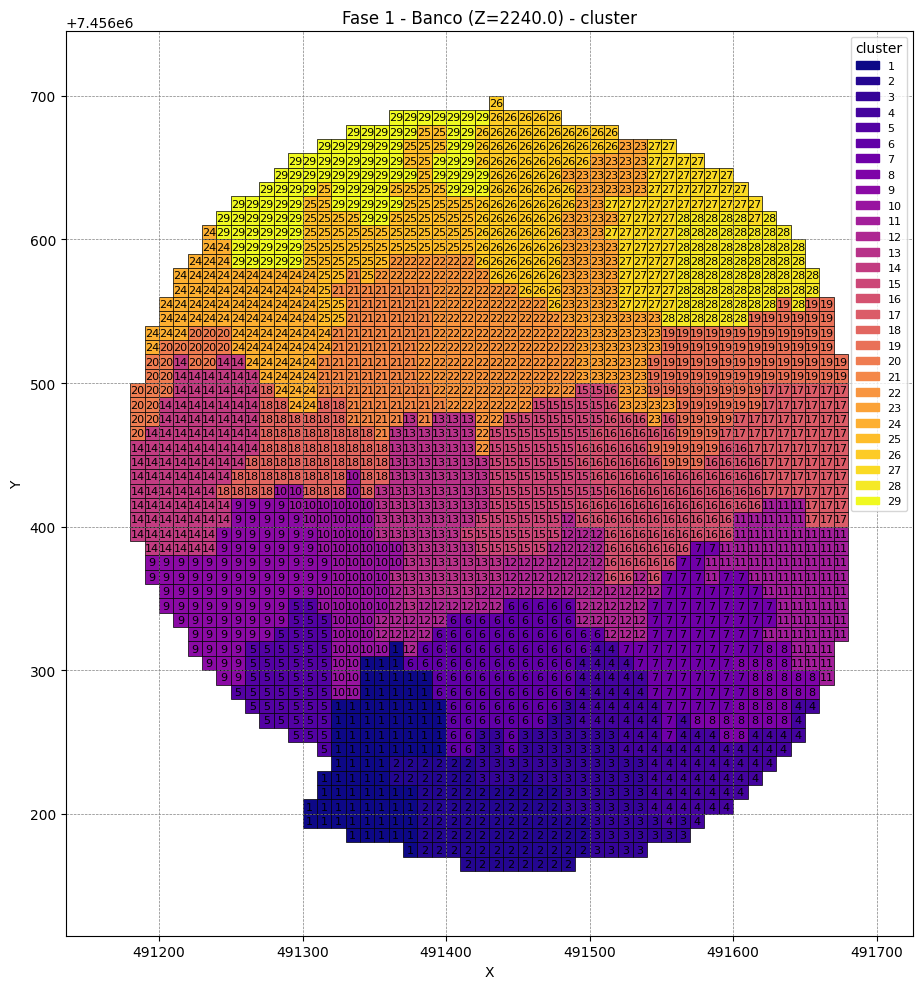

In [43]:
tbsh.plot_fase_banco(df_sup, 'cluster')

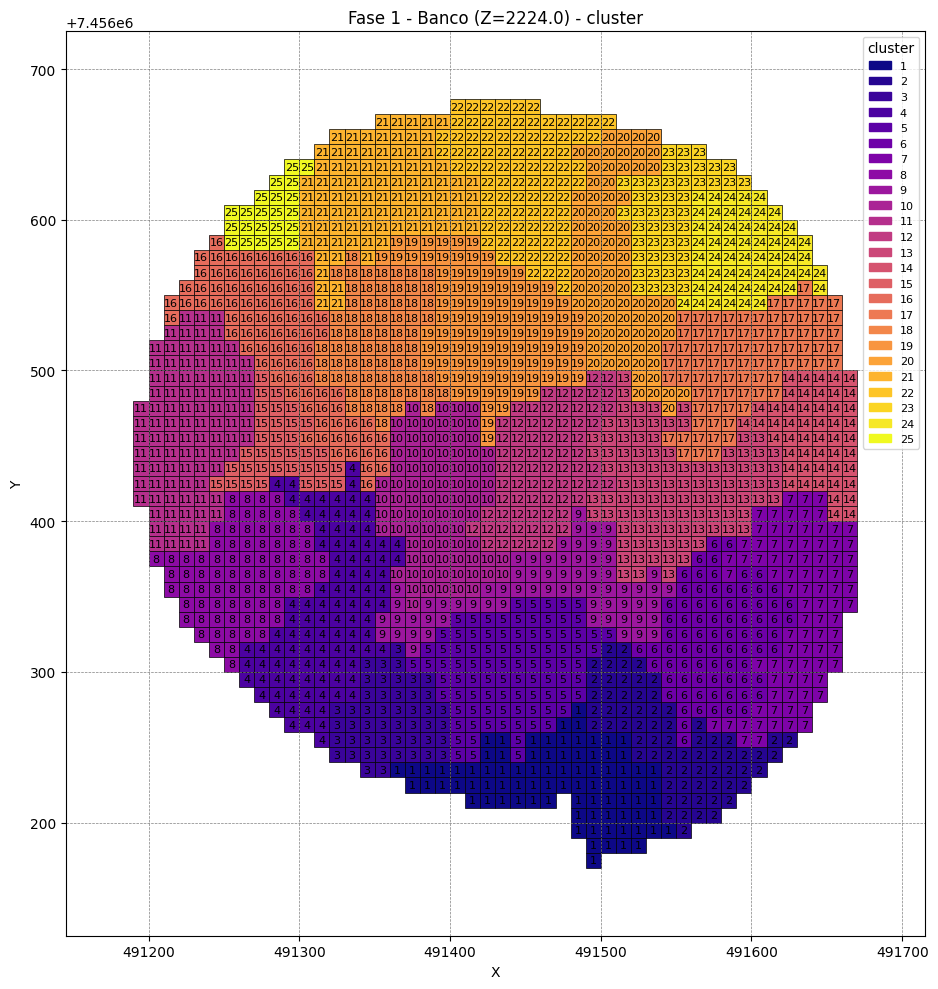

In [44]:
tbsh.plot_fase_banco(df_inf, 'cluster')

Tratando 'cluster' como Categórica (29 valores únicos).


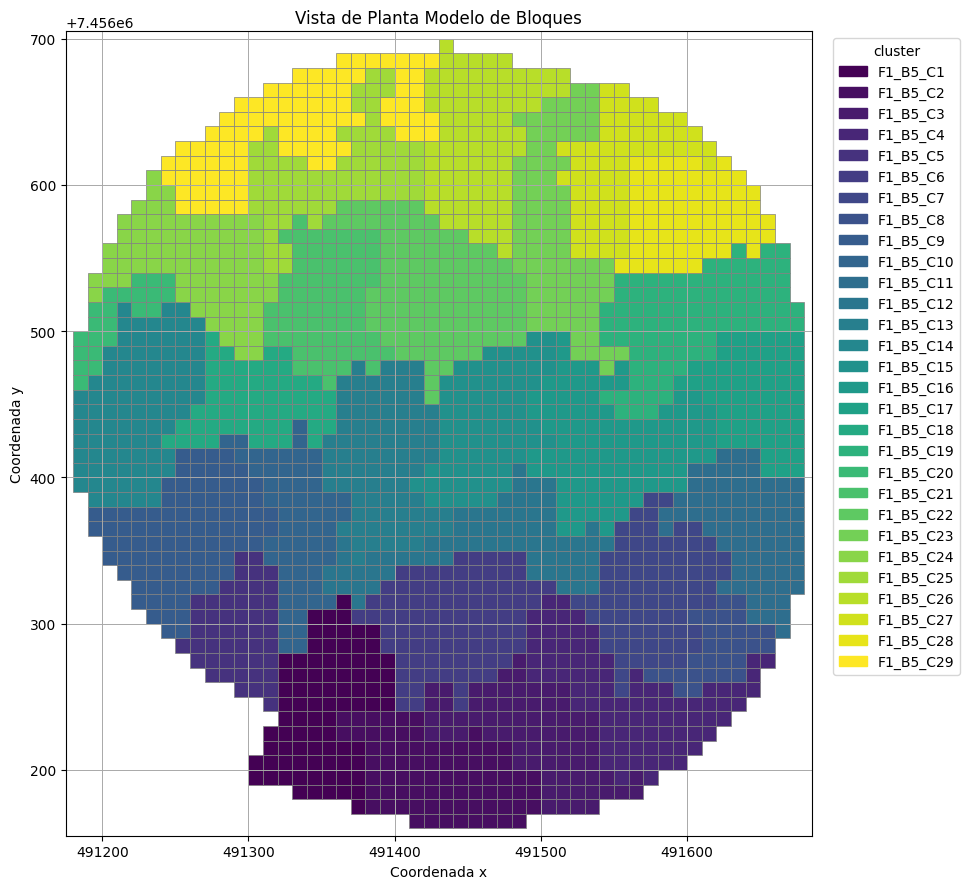

In [ ]:
df_mina_clustered = pd.read_csv("df_mina_clustered_4.csv")
df = df_mina_clustered.copy()
f,b = 1,5
df = df[(df['fase']==f)&(df['banco']==b)]
df.reset_index(inplace=True, drop=True)
df.rename(columns={'final_cluster_label': 'cluster'}, inplace=True)
aux.plot_mine_blocks_adv(df, 'cluster')


In [10]:
A = tbsh.Calculate_Adjency_Matrix(df, 10)
df2 = tbsh.Shape_Refinement_Tabesh(df, A, Min_Cluster_Length=20, Iterations_PostProcessing= 50)

========PostProcessing Results========
Total de clusters: 29
Tiempo: 63.86706614494324


In [6]:
df2[0]

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id,banco,final_cluster_id,cluster
0,491375.0,7456175.0,2240.0,0.026555,0.050147,0.017366,0.001928,0.017366,2.472998,0,0.0,0.0,0.0,0.111023,0,1,55385,5,1,F1_B5_C1
1,491385.0,7456175.0,2240.0,0.024233,0.125937,0.043612,0.012661,0.043612,2.470923,0,0.0,0.0,0.0,0.290298,0,1,55386,5,2,F1_B5_C2
2,491395.0,7456175.0,2240.0,0.024233,0.125937,0.043612,0.012661,0.043612,2.470923,0,0.0,0.0,0.0,0.290298,0,1,55387,5,2,F1_B5_C2
3,491415.0,7456165.0,2240.0,0.010305,0.130463,0.045179,0.014165,0.045179,2.485071,0,0.0,0.0,0.0,0.313523,0,1,55410,5,2,F1_B5_C2
4,491425.0,7456165.0,2240.0,0.010097,0.149698,0.051840,0.013722,0.051840,2.512373,0,0.0,0.0,0.0,0.264695,0,1,55411,5,2,F1_B5_C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,491525.0,7456665.0,2240.0,0.077704,0.382872,0.132589,0.083393,0.132589,2.604985,1,0.0,0.0,0.0,0.628958,1,1,69001,5,23,F1_B5_C23
2133,491535.0,7456665.0,2240.0,0.077704,0.382872,0.132589,0.083393,0.132589,2.604985,1,0.0,0.0,0.0,0.628958,1,1,69002,5,23,F1_B5_C23
2134,491545.0,7456665.0,2240.0,0.079933,0.367093,0.127124,0.073981,0.127124,2.613966,1,0.0,0.0,0.0,0.581956,1,1,69003,5,27,F1_B5_C27
2135,491555.0,7456665.0,2240.0,0.079933,0.367093,0.127124,0.073981,0.127124,2.613966,1,0.0,0.0,0.0,0.581956,1,1,69028,5,27,F1_B5_C27


Tratando 'cluster' como Categórica (29 valores únicos).


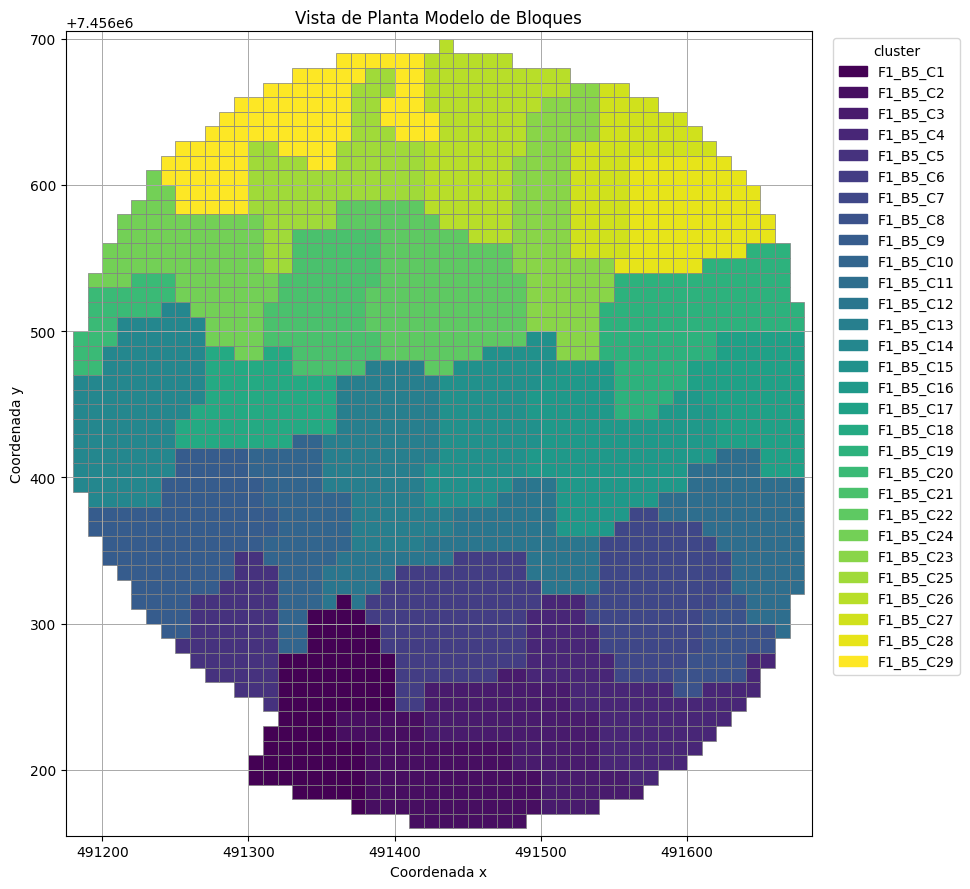

In [11]:
aux.plot_mine_blocks_adv(df2[0], 'cluster')

In [7]:
df_mina_clustered['final_cluster_label'].unique()

array(['F4.0_B22_C1', 'F4.0_B22_C2', 'F4.0_B22_C3', ..., 'F3.0_B1_C4',
       'F3.0_B2_C5', 'F3.0_B2_C6'], shape=(1250,), dtype=object)

In [ ]:
params = {
    'max_cluster_size': 8,
    'target_num_clusters': 5,
    'distancia_adyacencia': 15.0, # Ajustar según escala de coordenadas
    'wd': 0.1,
    'wg': 1.0,
    'r': 0.3 # Factor si material es igual (¡0.3 reduce similitud!)
}

In [4]:
df_copy = df_mina_clustered.copy()

In [5]:
df_copy['final_cluster_label']

0        F4_B22_C1
1        F4_B22_C1
2        F4_B22_C1
3        F4_B22_C1
4        F4_B22_C1
           ...    
91277     F3_B2_C6
91278     F3_B2_C6
91279     F3_B2_C6
91280     F3_B2_C6
91281     F3_B2_C6
Name: final_cluster_label, Length: 91282, dtype: object

Las siguientes celdas hacen graficos por banco de la fase 1 para comparar los clusters

In [8]:
f = 1
fase_data = df_copy[df_copy['fase'] == f]
x_min_global = fase_data['x'].min() - 5*10
x_max_global = fase_data['x'].max() + 5*10
y_min_global = fase_data['y'].min() - 5*10
y_max_global = fase_data['y'].max() + 5*10

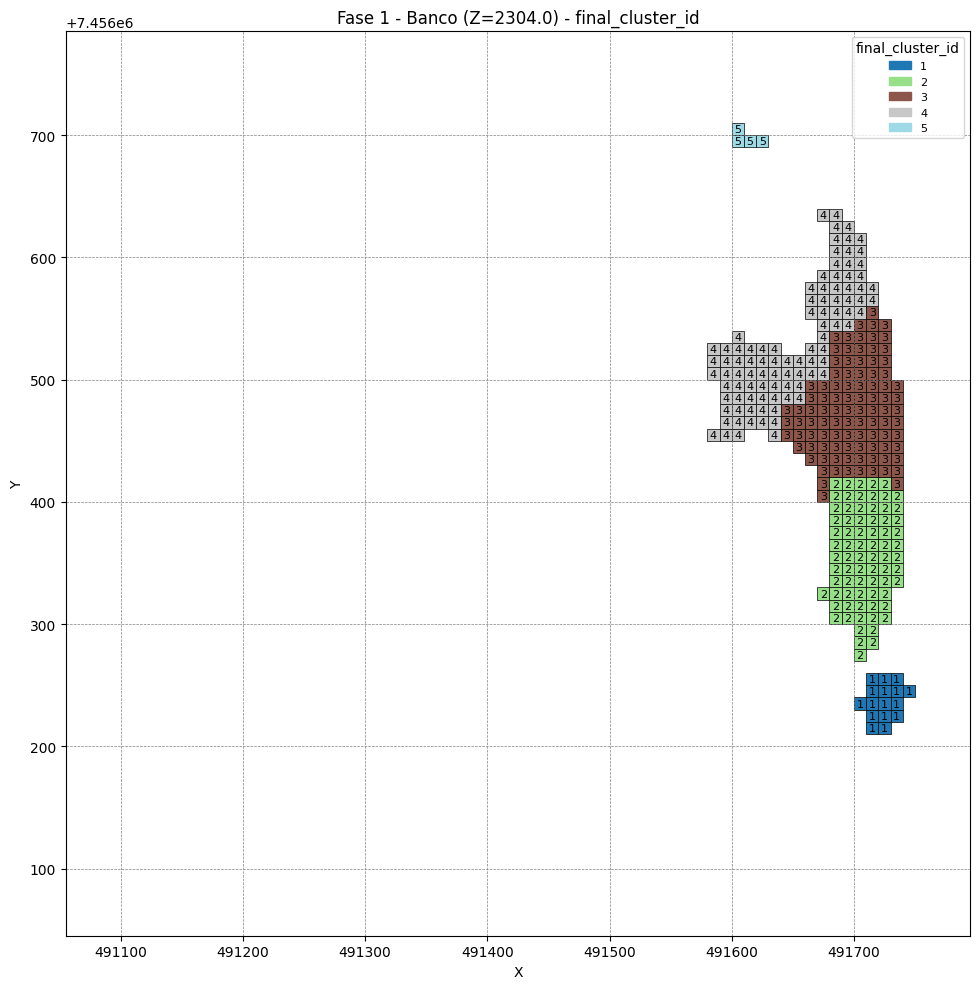

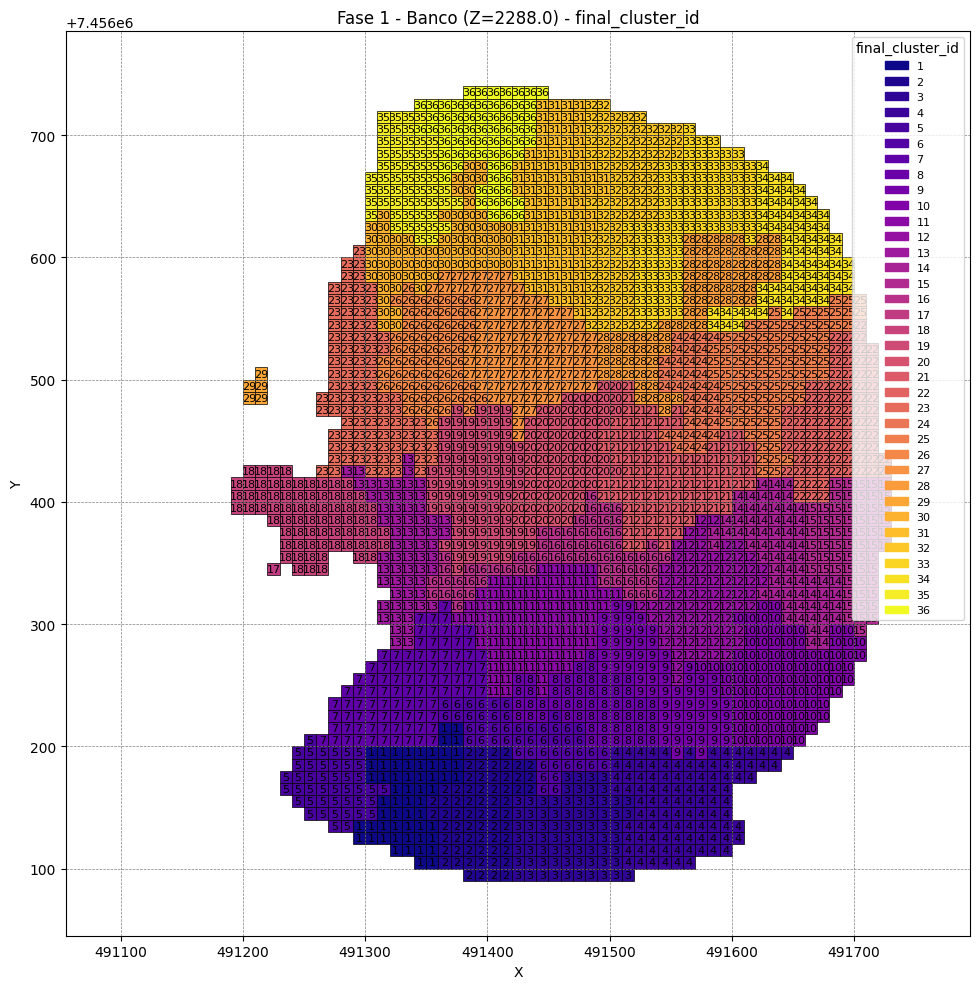

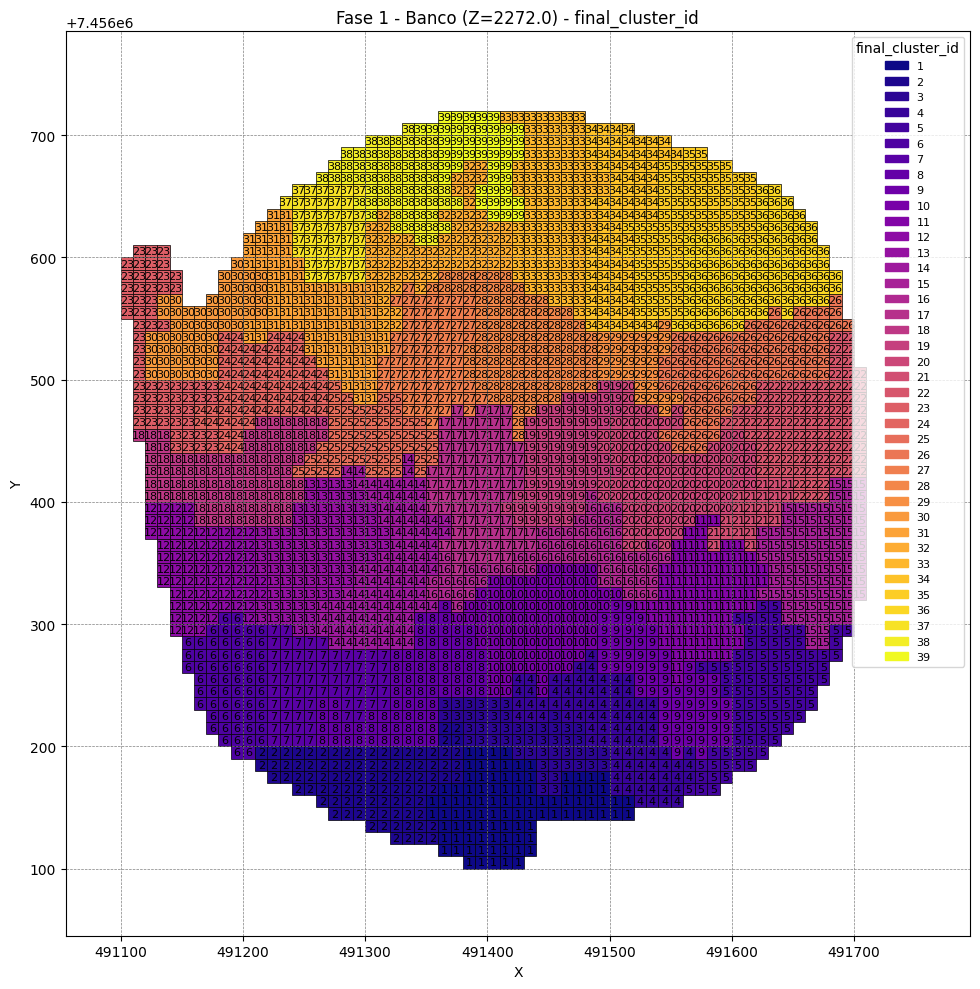

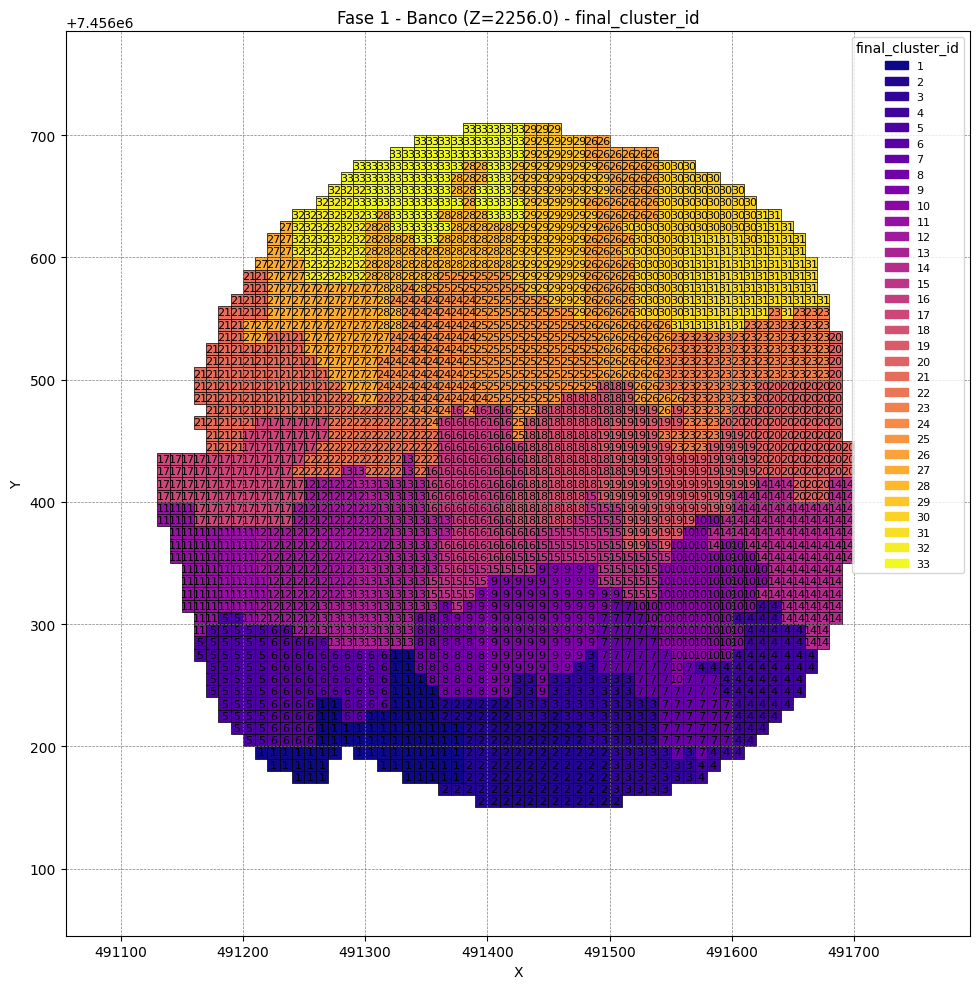

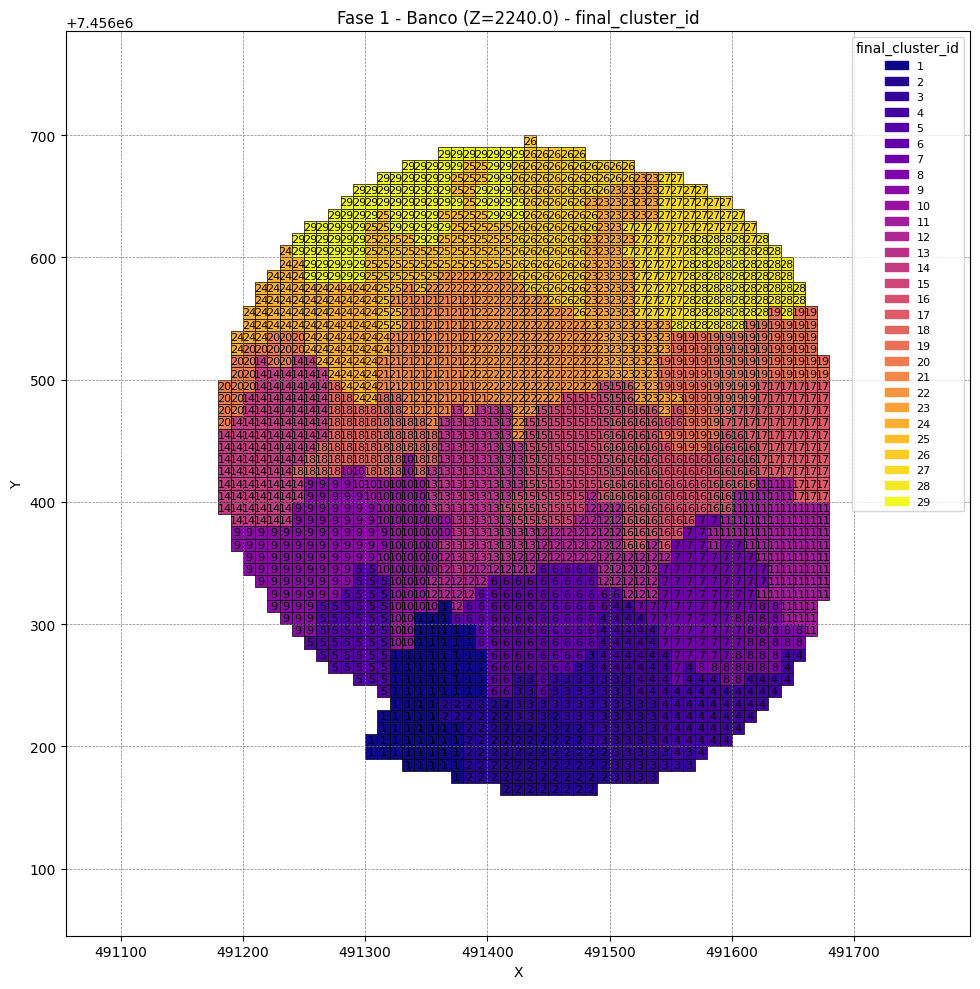

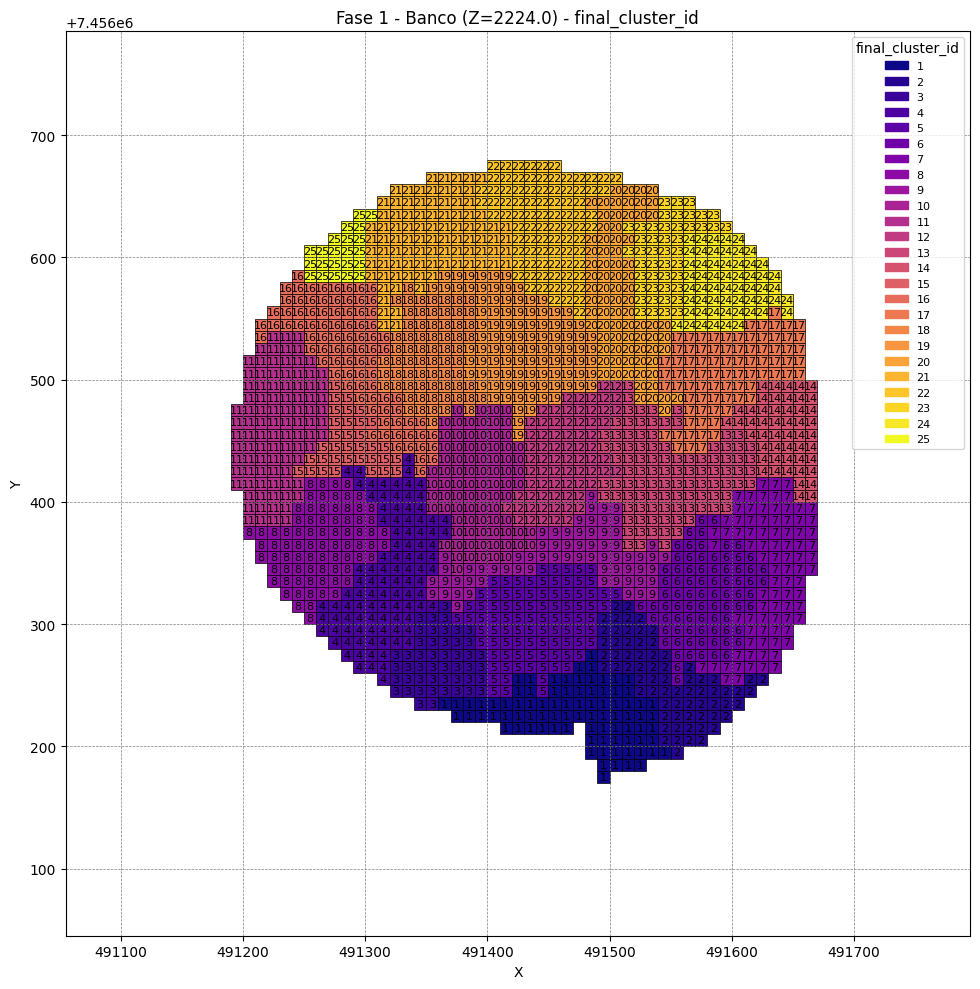

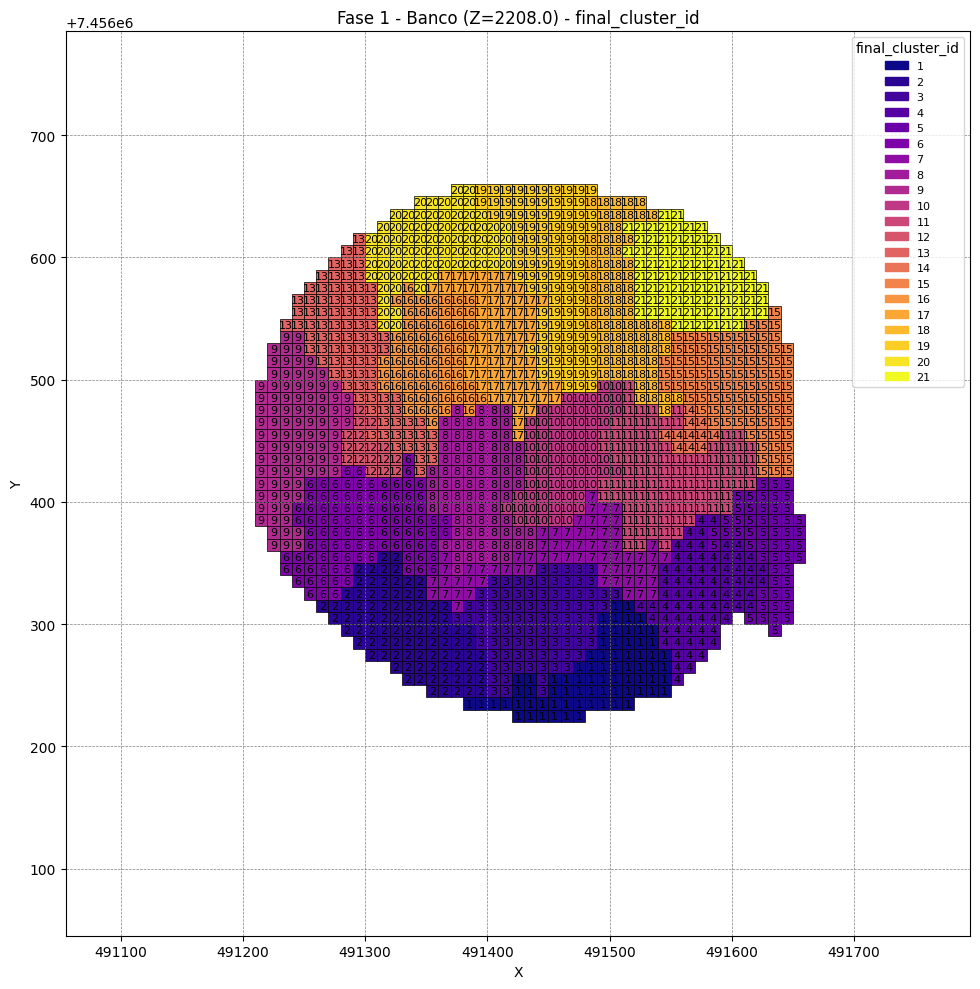

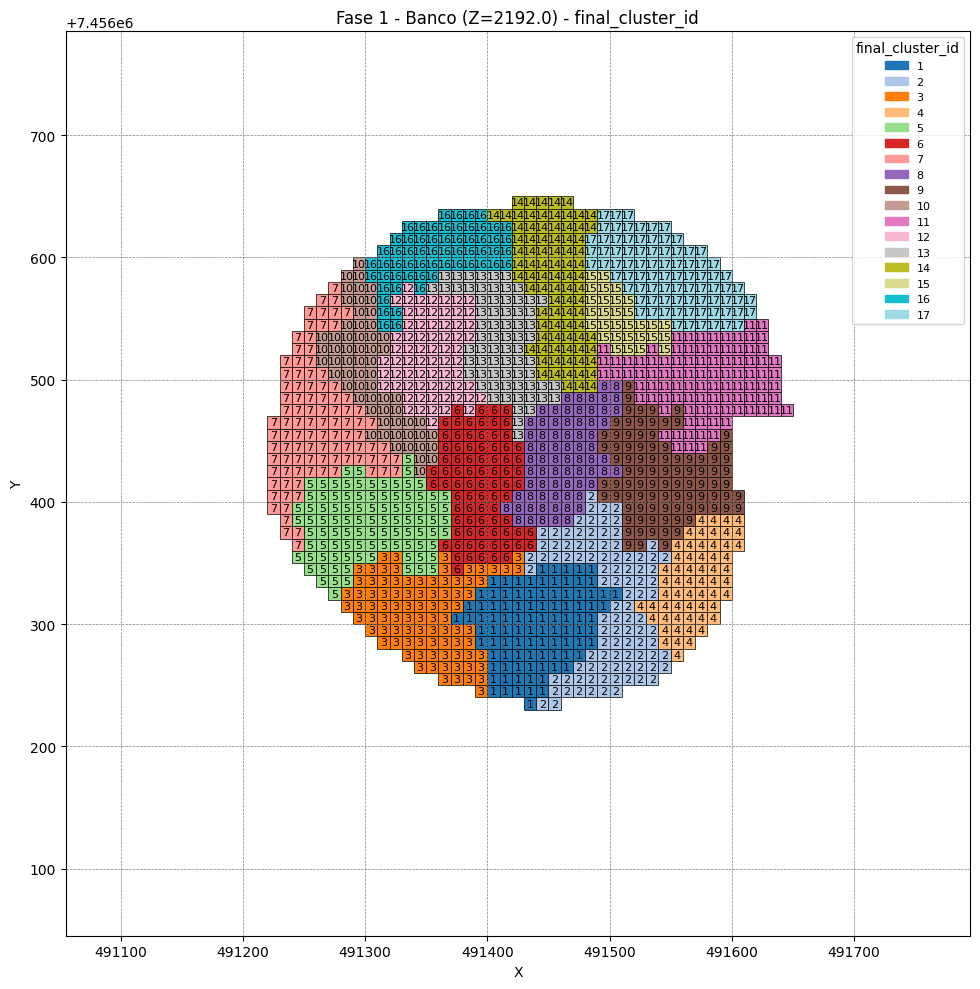

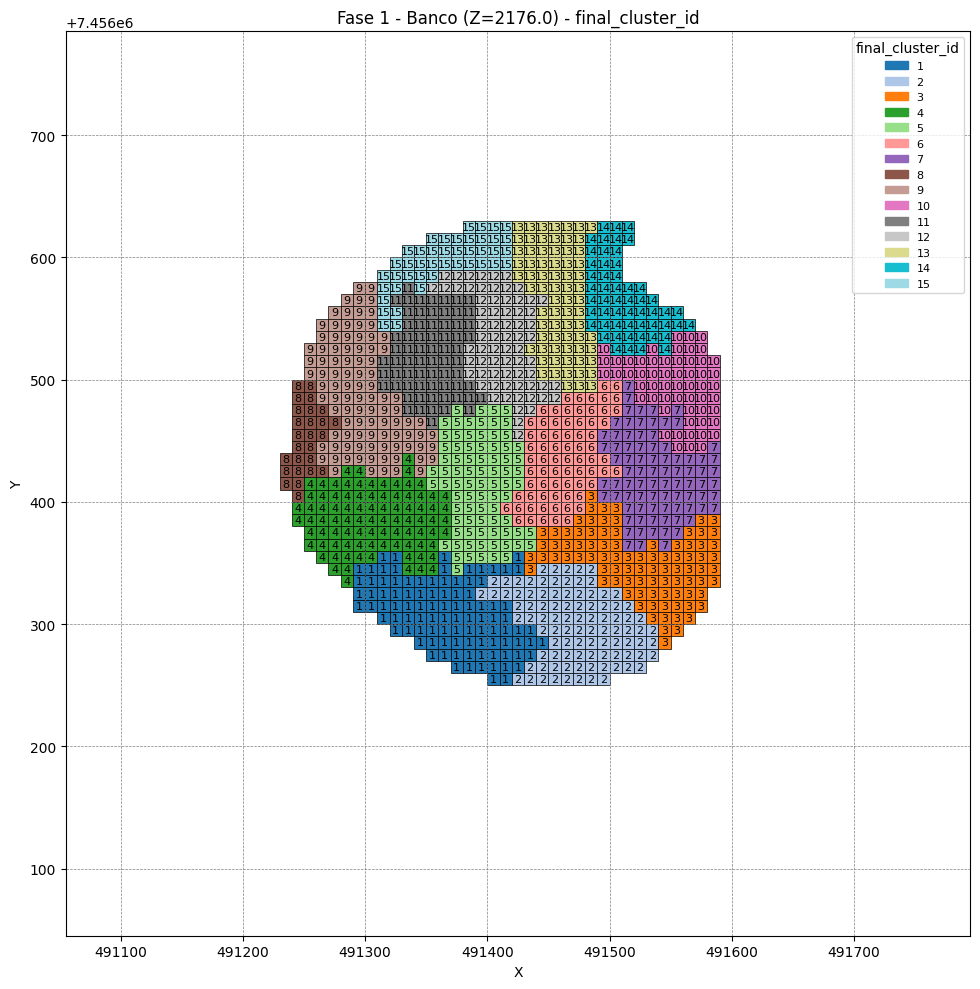

In [9]:
for b in range(1, 10):
    df_ = df_copy[(df_copy['fase'] == f) & (df_copy['banco'] == b)]
    tbsh.plot_fase_banco(df_, column_hue='final_cluster_id',
                         xlim=(x_min_global, x_max_global),
                         ylim=(y_min_global, y_max_global))